# Project Description

Recommendation engines play a critical role in customer engagement and retention for online media and entertainment industry.
Recommendation Engines are the programs which basically compute the similarities between two entities and on that basis, they give us the targeted output.
This movie recommendation system recommends movies to a user or a client by evaluating data set.


# Problem Statement

Build a movie recommendation system based on the user ratings 
General recommendation system: 
As for recommendation, for this method, we always recommend those movies with the highest average rating and more than certain number of ratings.
User based recommendation system:
Used similarities between the user ratings and predicted the recommendations for the user.


# Data Source

https://www.kaggle.com/netflix-inc/netflix-prize-data

# Code :

In [ ]:
!pip install PyDrive

In [ ]:
!pip install Pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 15.2 MB/s 
  Created wheel for Pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=fb22fedbeca5545498600b472c0a154da94d59cc19b2269fc30a6ee30a4d0886
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built Pyspark


Importing the relavent libraries

In [ ]:
import os
from pyspark import SparkConf, SparkContext
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime as dt
from time import time
from pyspark.mllib.recommendation import ALS
import math
from collections import OrderedDict
from google.colab import drive
import sys
%matplotlib inline 

# Data Collection

Mounting the data file to google colab

In [ ]:
g_drive_path = '/content/gdrive/MyDrive/archive'
drive.mount('/content/gdrive/')
sys.path.append(g_drive_path)

Mounted at /content/gdrive/


In [ ]:
os.chdir('/content/gdrive/MyDrive/archive')

In [ ]:
!ls   #Listing all  files in the colab directory

combined_data_1.txt  combined_data_4.txt  probe.txt
combined_data_2.txt  data.csv		  qualifying.txt
combined_data_3.txt  movie_titles.csv	  README


Starting the spark kernel

In [ ]:
conf = SparkConf().setMaster("local").setAppName("Project")
sc = SparkContext(conf=conf)

Merging all the data files into a single file

In [ ]:
start = time()
files=['combined_data_1.txt','combined_data_2.txt', 
           'combined_data_3.txt', 'combined_data_4.txt']
data = open('data.csv', mode='w')
for file in files:
    print("Reading ratings from {}...".format(file))
    with open(file) as f:
        for line in f: 
            #del row[:]  you don't have to do this.
            line = line.strip()
            if line.endswith(':'):
                # All below are ratings for this movie, until another movie appears.
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
    print("Done.\n")
data.close()
print('Time taken :', time() - start)

Reading ratings from combined_data_1.txt...
Done.

Reading ratings from combined_data_2.txt...
Done.

Reading ratings from combined_data_3.txt...
Done.

Reading ratings from combined_data_4.txt...
Done.

Time taken : 228.88085293769836


Creating RDDs

In [ ]:
ratings_rdd = sc.textFile('data.csv')

In [ ]:
movies_rdd = sc.textFile('movie_titles.csv')

In [ ]:
ratings_rdd.take(5)

['1,1488844,3,2005-09-06',
 '1,822109,5,2005-05-13',
 '1,885013,4,2005-10-19',
 '1,30878,4,2005-12-26',
 '1,823519,3,2004-05-03']

In [ ]:
movies_rdd.take(5)

['1,2003,Dinosaur Planet',
 '2,2004,Isle of Man TT 2004 Review',
 '3,1997,Character',
 "4,1994,Paula Abdul's Get Up & Dance",
 '5,2004,The Rise and Fall of ECW']

# Data Cleaning

In [ ]:
ratings_rdd = ratings_rdd.distinct()    #Removing duplicate entries

In [ ]:
def getRatingTuple(line):
    items = line.replace("\n", "").split(",")
    try:
        return int(items[0]), int(items[1]), float(items[2]) #Removing the date field in ratings_rdd as it is not useful for our analysis.
    except ValueError:
        pass

def getMovieTuple(line):
    items = line.replace("\n", "").split(",") 
    try:
        return int(items[0]), items[2]  #Removing the year field in movies_rdd as it is not useful for our analysis.
    except ValueError:
        pass

In [ ]:
ratingsRDD = ratings_rdd.map(lambda x: getRatingTuple(x)).cache()
moviesRDD = movies_rdd.map(lambda x: getMovieTuple(x)).cache()

In [ ]:
ratingsRDD.take(5)

[(1, 558634, 4.0),
 (1, 2287003, 5.0),
 (1, 1027056, 3.0),
 (1, 573434, 4.0),
 (1, 1563530, 4.0)]

In [ ]:
moviesRDD.take(5)

[(1, 'Dinosaur Planet'),
 (2, 'Isle of Man TT 2004 Review'),
 (3, 'Character'),
 (4, "Paula Abdul's Get Up & Dance"),
 (5, 'The Rise and Fall of ECW')]

#Exploratory Data Analysis

In [ ]:
ratingsCount = ratingsRDD.count()
moviesCount = moviesRDD.count()

In [ ]:
 print("The length of ratings dataset is {0} and length of movie title dataset is {1}".format(ratingsCount,moviesCount))

The length of ratings dataset is 100480507 and length of movie title dataset is 17770


In [ ]:
eda_rdd = ratingsRDD.sample(False,fraction = 0.0001)

In [ ]:
eda_rdd.take(1)

[(257, 374783, 5.0)]

In [ ]:
# print("Length of data taken for visualisation =",eda_rdd.count())

In [ ]:
def rating_distribution(ratings_rdd):
  return ratings_rdd.map(lambda x: x[2]).countByValue().items()


ratingscoreDict = {x[0]:x[1] for x in rating_distribution(eda_rdd)}   #Creating a dictionary with rating as key and rating count as value

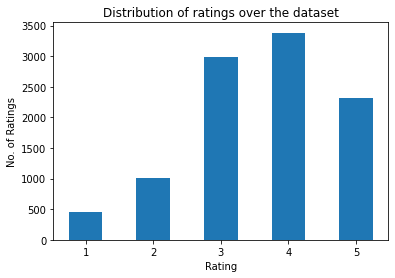

In [ ]:
plt.figure()
plt.bar(ratingscoreDict.keys(), ratingscoreDict.values(), 0.5)
plt.xlabel('Rating')
plt.ylabel('No. of Ratings')
plt.title('Distribution of ratings over the dataset')
plt.show()

In [ ]:
def ratings_per_movie_distribution(ratings_rdd):
    return ratings_rdd.map(lambda x: x[1]).countByValue().items()

#Creating a dictionary with movie as key and number of ratings per movie as value
no_of_ratings_per_movie = {x[0]:x[1] for x in ratings_per_movie_distribution(eda_rdd)}

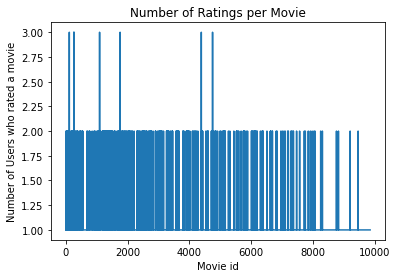

In [ ]:
plt.figure()
plt.plot(list(no_of_ratings_per_movie.values()))
plt.title('Number of Ratings per Movie')
plt.xlabel('Movie id')
plt.ylabel('Number of Users who rated a movie')
plt.show()


Creating train, validation and test dataset

In [ ]:
training_RDD, validation_RDD, test_RDD = ratingsRDD.randomSplit([6, 2, 2])
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))            #Removing ratings value in validation 
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))                        #and test dataset for testing

In [ ]:
#print("Length of Training dataset = {0} Validation dataset = {1} Test Dataset = {2}",training_RDD.count(),validation_RDD.count(),test_RDD.count())

# Machine Learning model

In [ ]:
iterations = 10     # No of iterations
regularization_parameter = 0.1     # Setting regularisation parameter
ranks = [4, 8, 12]      # Hyperparameter
errors = [0, 0, 0]      # To measure the error for each value of rank
err = 0                 # To store index of error values

min_error = float('inf')   # To store lowest error value, setting initial value as infinite
best_rank = -1             # To store best rank value
best_iteration = -1        # To store best iteration value
start = time()
for rank in ranks:
    model = ALS.train(training_RDD, rank, iterations=iterations, lambda_=regularization_parameter)   #Training the model
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda x: ((x[0], x[1]), x[2]))   #Predicting the rating for validation dataset
    actual_and_pred_rating = validation_RDD.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
    error = math.sqrt(actual_and_pred_rating.map(lambda x: (x[1][0] - x[1][1])**2).mean())           #Calculating mean square error for each row
    errors[err] = error
    err += 1
    print('For rank {0} the RMSE is {1}'.format(rank, error))
    if error < min_error:                                                                           #To find best rank value and least error value
        min_error = error
        best_rank = rank

end = time() - start
print('The best model was trained with rank',best_rank)

print("Model trained in {0} seconds".format(round(end,3)))

For rank 4 the RMSE is 0.884054551449582
For rank 8 the RMSE is 0.8713566797793022
For rank 12 the RMSE is 0.8688835515815428
The best model was trained with rank 12
Model trained in 10525.488 seconds


Training the dataset with the best hyperparameters to find RMSE on test data

In [ ]:
start = time()
model = ALS.train(training_RDD, best_rank, iterations=iterations, lambda_=regularization_parameter)
end = time() - start
print("Model trained in {0} seconds".format(round(end,3)))

predictions = model.predictAll(test_for_predict_RDD).map(lambda x: ((x[0], x[1]), x[2]))
actual_and_pred_rating = test_RDD.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
error = math.sqrt(actual_and_pred_rating.map(lambda x: (x[1][0] - x[1][1])**2).mean())
    
print('For testing data the RMSE is ',error)

Model trained in 1730.165 seconds
For testing data the RMSE is  0.8692185631535375


# Recommendation engine

In [ ]:
def get_counts_and_averages(ID_and_ratings_tuple):    #Getting counts and average rating of all movies
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

movie_ID_with_ratings_RDD = (ratingsRDD.map(lambda x: (x[1], x[2])).groupByKey())
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))

Creating a new user to get movie recommendations, with user ID as 0

In [ ]:
new_user_ID = 0

# The format of each line is (userID, movieID, rating)
# Assigning random value to the new_user_ratings
new_user_ratings = [
     (0,175,4), # Reservoir Dogs (1992)
     (0,252,3), # Stuart Little 2 (2002)
     (0,457,3), # Kill Bill: Vol. 2 (2004)
     (0,465,4), # Coolie No.1 (1995)
     (0,483,4), # Rush Hour 2 (2001)
     (0,621,1), # Armageddon (1997)
     (0,633,1), # Baazigar (1993)
     (0,1477,3), # Aradhana (1969)
     (0,1524,5) , # American Ninja (1995)
     (0,1623,4) # Pokemon Advanced (2003)
    ]
new_user_ratings_RDD = sc.parallelize(new_user_ratings)   #Creating an Rdd for new user data
print('New user ratings: ',new_user_ratings_RDD.take(5))

New user ratings:  [(0, 175, 4), (0, 252, 3), (0, 457, 3), (0, 465, 4), (0, 483, 4)]


In [ ]:
data_with_new_ratings_RDD = ratingsRDD.union(new_user_ratings_RDD)  #merging new user data with the original data

Training the model with the merged data 

In [ ]:
start = time()
new_ratings_model = ALS.train(data_with_new_ratings_RDD, rank = best_rank, 
                              iterations=iterations, lambda_=regularization_parameter)
end = time() - start

print("New model trained in {0} seconds".format(round(end,3)))

New model trained in 2560.957 seconds


Predicting ratings for movies not yet watched by the user

In [ ]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # getting just movie IDs
#Creating a rdd of tuple of new user id and all movie ids except those movie that the user has already watched and rated
new_user_movies_unrated_RDD = (moviesRDD.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

#Predicting new ratings as suitable for the new user for the movies that the new user has not watched yet using the model
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_movies_unrated_RDD)

In [ ]:
#Joing the movie title and movie count to recommend the top movies to the new user
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = new_user_recommendations_rating_RDD.join(moviesRDD).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda x: (x[1][0][1], x[1][0][0], x[1][1]))

Recommending top 10 movies to the new user

In [ ]:
recommended_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda x: x[2]>=25).takeOrdered(10, key=lambda x: -x[1])

print('TOP recommended movies (with more than 25 reviews):\n')
print('Movies, Ratings, Movie count')
for i in range(len(recommended_movies)):
  print(recommended_movies[i])

TOP recommended movies (with more than 25 reviews):

Movies, Ratings, Movie count
('Melody Time', 2.2586089928027984, 27)
("Arthur's Quest", 2.174830462197871, 50)
('Wilder Napalm', 1.9698531364651988, 48)
('Glory', 1.9489442805675408, 47)
('David Byrne: Live at Union Chapel', 1.9377096202696007, 78)
('It Came From Outer Space', 1.921228442246896, 46)
('Lewis & Clark & George', 1.8391446224820007, 57)
('The History Channel Presents: The Alamo', 1.8089732768846831, 50)
('Murder by Death', 1.8057059284288854, 28)
('Guncrazy', 1.8050097674319998, 46)


In [ ]:
recommended_movies = sc.parallelize(recommended_movies)    #Converting the list object to rdd

# Visualisation

Creating visualisation of recommended movies(x-axis) vs movie counts(y-axis)

In [ ]:
def count_movies(rdd):
    return rdd.map(lambda x: (x[0],x[2])).collect()

countDict = {x[0]:x[1] for x in count_movies(recommended_movies)} 
countDict = OrderedDict(reversed(list(countDict.items())))  #https://www.geeksforgeeks.org/python-reverse-dictionary-keys-order/

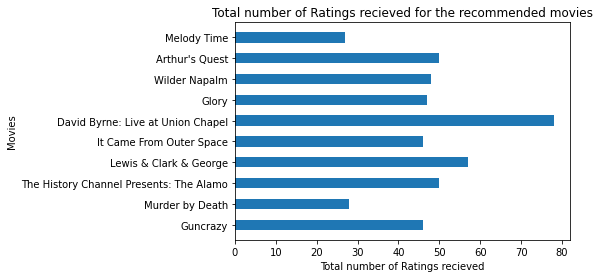

In [ ]:
plt.figure()
plt.barh(list(countDict.keys()),countDict.values(), 0.5)
plt.xlabel('Total number of Ratings recieved')
plt.ylabel('Movies')
plt.title('Total number of Ratings recieved for the recommended movies')
plt.show()

Creating visualisation of recommended movies(x-axis) vs avg ratings(y-axis) 

In [ ]:
def ratings_of_movies(rdd):
    return rdd.map(lambda x: (x[0],x[1])).collect()

ratingsDict = {x[0]:x[1] for x in ratings_of_movies(recommended_movies)}
ratingsDict = OrderedDict(reversed(list(ratingsDict.items())))   #https://www.geeksforgeeks.org/python-reverse-dictionary-keys-order/

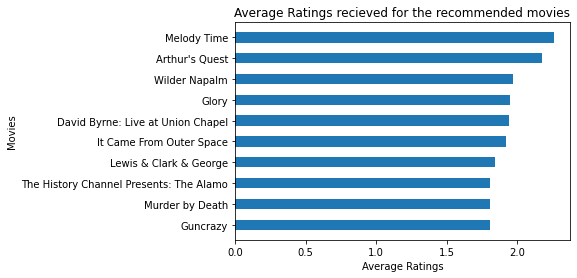

In [ ]:
plt.figure()
plt.barh(list(ratingsDict.keys()),ratingsDict.values(), 0.5)
plt.xlabel('Average Ratings')
plt.ylabel('Movies')
plt.title('Average Ratings recieved for the recommended movies')
plt.show()

# Conclusion

Best Hyperparameter rank value = 12


For rank 12, for validation dataset, the RMSE is 0.868952762409848

For testing data the RMSE is  0.868124746411092

Top recommended movies for new user are:
1.  'A Bullet in the Head'
2.  'Snake & Crane Arts of Shaolin'
3.  'Eddie Izzard: Circle'
4.  'Mandragora'
5.  'Phone Booth'
6.  'Space Battleship Yamato: The Movie'
7.  'Mission Kashmir'
8.  'City of Women'
9.  'Embrace the Darkness 2'
10. 'Little House on the Prairie: Season 6'